# Cryptanalysis of Image Encryption System

Implements three types of attacks:

1.  **Brute Force Attack**: Tests key parameters to gauge computational infeasibility.
2.  **Known Plaintext Attack**: Analyzes plaintext-ciphertext pairs to find vulnerabilities.
3.  **Statistical Attack**: Analyzes histograms, correlation, and entropy to find statistical weaknesses.


## 1. Imports and Setup

Import all necessary libraries. The `%matplotlib inline` magic command ensures that plots are displayed directly in the notebook.


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from scipy.stats import entropy, pearsonr
from collections import Counter
import hashlib

# Ensure plots appear inline in the notebook
%matplotlib inline

# --- Local Dependencies ---
# These files must be in the same directory as this notebook
try:
    from substitute_perbutate import FresnelSubstitution, PixelPerturbation
    from aes import encrypt_array, decrypt_array
    print("Local dependencies (substitute_perbutate, aes) loaded successfully.")
    try:
        from key_generation import key_gen
        print("key_generation loaded successfully.")
    except ImportError:
        print("Note: key_generation not loaded (not required for cryptanalysis)")
except ImportError as e:
    print(f"Error: Could not import local dependencies. {e}")
    print("Please make sure 'substitute_perbutate.py' and 'aes.py' are in the same directory.")

Local dependencies (substitute_perbutate, aes) loaded successfully.
Note: key_generation not loaded (not required for cryptanalysis)


## 2. Attack 1: Brute Force Attack

This class attempts to demonstrate the difficulty of a brute-force attack by sampling the key-space for:

- Substitution seeds
- Perturbation parameters
- AES key (demonstrating computational infeasibility)


In [3]:
class BruteForceAttack:
    """
    Brute force attack on the encryption system
    Tests different combinations of encryption parameters
    """

    def __init__(self, encrypted_image):
        self.encrypted_image = encrypted_image
        self.height, self.width = encrypted_image.shape

    def attack_substitution_seeds(self, max_seed_value=10000, sample_size=100):
        """
        Try to brute force the substitution seeds
        Only tests a sample due to large keyspace
        """
        print("="*70)
        print("BRUTE FORCE ATTACK - SUBSTITUTION SEEDS")
        print("="*70)
        print(
            f"Keyspace size: {max_seed_value}^2 = {max_seed_value**2:,} combinations")
        print(f"Testing random sample of {sample_size} combinations...")

        start_time = time.time()
        attempts = 0

        # Random sampling approach (full brute force would take too long)
        np.random.seed(42)
        seed_pairs = np.random.randint(
            0, max_seed_value, size=(sample_size, 2))

        results = []

        for seed_d, seed_f in seed_pairs:
            attempts += 1

            try:
                fs = FresnelSubstitution(
                    seed_d=int(seed_d), seed_f=int(seed_f))

                # Try to decrypt first row as a test
                test_row = self.encrypted_image[0, :]
                decrypted_row = fs.substitute_inv(test_row)

                # Calculate metrics
                entropy_val = entropy(np.bincount(
                    decrypted_row, minlength=256))

                results.append({
                    'seed_d': seed_d,
                    'seed_f': seed_f,
                    'entropy': entropy_val,
                    'decrypted_sample': decrypted_row
                })

                if attempts % 20 == 0:
                    print(f"  Tested {attempts}/{sample_size} combinations...")

            except Exception as e:
                continue

        elapsed_time = time.time() - start_time

        print(f"\nCompleted {attempts} attempts in {elapsed_time:.2f} seconds")
        print(f"Average time per attempt: {elapsed_time/attempts:.4f} seconds")
        print(
            f"\nEstimated time for full brute force of {max_seed_value**2:,} combinations:")
        print(
            f"  {(elapsed_time/attempts * max_seed_value**2 / 3600 / 24):.2f} days")

        # Sort by entropy (lower entropy might indicate correct decryption)
        results.sort(key=lambda x: x['entropy'])

        print(f"\nTop 5 candidates (by entropy):")
        for i, result in enumerate(results[:5]):
            print(
                f"  {i+1}. seed_d={result['seed_d']}, seed_f={result['seed_f']}, entropy={result['entropy']:.4f}")

        return results

    def attack_perturbation_params(self, r_range=(3.5, 4.0), x_range=(0.0, 1.0), sample_size=100):
        """
        Try to brute force perturbation parameters
        """
        print("\n" + "="*70)
        print("BRUTE FORCE ATTACK - PERTURBATION PARAMETERS")
        print("="*70)
        print(f"r parameter range: {r_range}")
        print(f"x parameter range: {x_range}")
        print(f"Testing {sample_size} random combinations...")

        start_time = time.time()
        attempts = 0

        results = []

        for _ in range(sample_size):
            attempts += 1

            # Random parameters
            r = np.random.uniform(r_range[0], r_range[1])
            x = np.random.uniform(x_range[0], x_range[1])

            try:
                pp = PixelPerturbation(r_init=r, x_init=x)
                pp.x_original = x

                # Try inverse perturbation
                test_decrypted = pp.perturbate_image_inverse(
                    self.encrypted_image.copy())

                # Calculate metrics
                entropy_val = entropy(np.bincount(
                    test_decrypted.ravel(), minlength=256))

                results.append({
                    'r': r,
                    'x': x,
                    'entropy': entropy_val
                })

                if attempts % 20 == 0:
                    print(f"  Tested {attempts}/{sample_size} combinations...")

            except Exception as e:
                continue

        elapsed_time = time.time() - start_time

        print(f"\nCompleted {attempts} attempts in {elapsed_time:.2f} seconds")

        # Sort by entropy
        results.sort(key=lambda x: x['entropy'])

        print(f"\nTop 5 candidates (by entropy):")
        for i, result in enumerate(results[:5]):
            print(
                f"  {i+1}. r={result['r']:.4f}, x={result['x']:.4f}, entropy={result['entropy']:.4f}")

        return results

    def attack_aes_key(self, key_length=32, sample_size=1000):
        """
        Demonstrate AES key brute force (computationally infeasible)
        """
        print("\n" + "="*70)
        print("BRUTE FORCE ATTACK - AES KEY (256-bit)")
        print("="*70)

        keyspace_size = 2 ** (key_length * 8)

        print(f"AES-256 keyspace size: 2^256 = {keyspace_size:.2e} keys")
        print(f"This is approximately 1.15 × 10^77 possible keys")

        # Test a tiny sample to estimate time
        start_time = time.time()

        for i in range(sample_size):
            # Generate random key
            random_key = np.random.bytes(key_length)
            # Simulate key test (just hash computation)
            _ = hashlib.sha256(random_key).digest()

        elapsed_time = time.time() - start_time
        time_per_key = elapsed_time / sample_size

        print(
            f"\nTested {sample_size} random keys in {elapsed_time:.4f} seconds")
        print(f"Time per key attempt: {time_per_key*1000:.6f} milliseconds")

        # Calculate infeasibility
        total_time_seconds = keyspace_size * time_per_key
        total_time_years = total_time_seconds / (365.25 * 24 * 3600)

        print(f"\n⚠️  COMPUTATIONAL INFEASIBILITY:")
        print(
            f"  Estimated time to test all keys: {total_time_years:.2e} years")
        print(f"  (This is longer than the age of the universe: ~1.38 × 10^10 years)")
        print(f"\n✓ CONCLUSION: Brute force attack on AES-256 is INFEASIBLE")

        return time_per_key

## 3. Attack 2: Known Plaintext Attack

This class assumes the attacker has access to one or more plaintext-ciphertext pairs. It attempts to:

- Analyze the substitution mapping (is it one-to-one?)
- Recover the perturbation (pixel shuffling) pattern.
- Perform differential analysis to find patterns in the difference between plain and cipher images.


In [4]:
class KnownPlaintextAttack:
    """
    Known plaintext attack - attacker has access to plaintext-ciphertext pairs
    """

    def __init__(self, plaintext_image, encrypted_image):
        self.plaintext = plaintext_image
        self.encrypted = encrypted_image

    def analyze_substitution_mapping(self):
        """
        Analyze the substitution mapping using known plaintext-ciphertext pairs
        """
        print("="*70)
        print("KNOWN PLAINTEXT ATTACK - SUBSTITUTION ANALYSIS")
        print("="*70)

        height, width = self.plaintext.shape

        # Collect pixel mappings
        mappings = {}

        for i in range(min(10, height)):  # Analyze first 10 rows
            for j in range(width):
                plain_pixel = self.plaintext[i, j]
                encrypted_pixel = self.encrypted[i, j]

                if plain_pixel not in mappings:
                    mappings[plain_pixel] = []
                mappings[plain_pixel].append(encrypted_pixel)

        print(f"\nAnalyzed {min(10, height)} rows")
        print(f"Found mappings for {len(mappings)} distinct plaintext values")

        # Check if mapping is one-to-one
        one_to_one = True
        for plain_val, encrypted_vals in mappings.items():
            unique_encrypted = set(encrypted_vals)
            if len(unique_encrypted) > 1:
                one_to_one = False
                break

        if one_to_one:
            print("\n⚠️  Mapping appears to be ONE-TO-ONE (vulnerable)")
            print("   Attacker can build a lookup table!")
        else:
            print("\n✓  Mapping is NOT one-to-one (more secure)")
            print("   Same plaintext value maps to different ciphertext values")

        # Show some example mappings
        print("\nExample mappings (first 5):")
        for i, (plain_val, encrypted_vals) in enumerate(list(mappings.items())[:5]):
            encrypted_set = set(encrypted_vals)
            print(f"  Plaintext {plain_val} → Ciphertext {encrypted_set}")

        return mappings

    def recover_perturbation_pattern(self, known_pairs=5):
        """
        Try to recover perturbation pattern from multiple plaintext-ciphertext pairs
        """
        print("\n" + "="*70)
        print("KNOWN PLAINTEXT ATTACK - PERTURBATION PATTERN RECOVERY")
        print("="*70)

        height, width = self.plaintext.shape

        # Create position mapping
        print(f"\nAnalyzing pixel position changes...")

        position_changes = []

        for i in range(min(height, 10)):
            for j in range(min(width, 10)):
                plain_val = self.plaintext[i, j]

                # Find where this pixel value appears in encrypted image
                matches = np.where(self.encrypted == plain_val)

                if len(matches[0]) > 0:
                    for k in range(min(len(matches[0]), 3)):
                        new_i, new_j = matches[0][k], matches[1][k]
                        position_changes.append({
                            'from': (i, j),
                            'to': (new_i, new_j),
                            'distance': np.sqrt((new_i - i)**2 + (new_j - j)**2)
                        })

        if position_changes:
            avg_distance = np.mean([pc['distance'] for pc in position_changes])
            max_distance = np.max([pc['distance'] for pc in position_changes])

            print(f"  Analyzed {len(position_changes)} position changes")
            print(f"  Average displacement: {avg_distance:.2f} pixels")
            print(f"  Maximum displacement: {max_distance:.2f} pixels")

            print("\n⚠️  Position changes are DETECTABLE")
            print("   With enough plaintext-ciphertext pairs, pattern could be reversed")
        else:
            print("\n✓  Could not easily track position changes")

        return position_changes

    def differential_analysis(self):
        """
        Differential cryptanalysis - analyze how small changes in plaintext affect ciphertext
        """
        print("\n" + "="*70)
        print("KNOWN PLAINTEXT ATTACK - DIFFERENTIAL ANALYSIS")
        print("="*70)

        # Calculate difference between plaintext and ciphertext
        diff = np.abs(self.plaintext.astype(int) - self.encrypted.astype(int))

        print(f"\nDifference statistics:")
        print(f"  Mean difference: {np.mean(diff):.2f}")
        print(f"  Std deviation: {np.std(diff):.2f}")
        print(f"  Min difference: {np.min(diff)}")
        print(f"  Max difference: {np.max(diff)}")

        # Check for patterns
        unique, counts = np.unique(diff, return_counts=True)

        print(f"\nDifference distribution:")
        print(f"  Number of unique differences: {len(unique)}")

        # Check if uniform
        expected_count = diff.size / 256
        chi_square = np.sum((counts - expected_count) ** 2 / expected_count)

        print(f"  Chi-square test statistic: {chi_square:.2f}")

        if chi_square < 300:  # Threshold for uniformity
            print("  ✓ Difference distribution is relatively UNIFORM (good)")
        else:
            print("  ⚠️  Difference distribution shows PATTERNS (vulnerable)")

        return diff

## 4. Attack 3: Statistical Attack

This class analyzes the statistical properties of the ciphertext, comparing them to the plaintext. It does not require knowing the key.

- **Histogram Analysis**: Checks if the ciphertext pixel distribution is uniform (high entropy), which is a sign of good encryption.
- **Correlation Analysis**: Checks if adjacent pixels in the ciphertext are correlated. High correlation is a weakness.
- **Information Leakage**: Checks if properties like image dimensions, mean, or variance are preserved, which could leak information.


In [5]:
class StatisticalAttack:
    """
    Statistical attack - analyze statistical properties of encrypted image
    """

    def __init__(self, plaintext_image, encrypted_image):
        self.plaintext = plaintext_image
        self.encrypted = encrypted_image

    def histogram_analysis(self):
        """
        Analyze histogram distribution
        """
        print("="*70)
        print("STATISTICAL ATTACK - HISTOGRAM ANALYSIS")
        print("="*70)

        # Calculate histograms
        plain_hist, _ = np.histogram(
            self.plaintext.ravel(), bins=256, range=(0, 256))
        encrypted_hist, _ = np.histogram(
            self.encrypted.ravel(), bins=256, range=(0, 256))

        # Normalize
        plain_hist = plain_hist / plain_hist.sum()
        encrypted_hist = encrypted_hist / encrypted_hist.sum()

        # Calculate uniformity
        uniform_dist = np.ones(256) / 256

        plain_chi2 = np.sum((plain_hist - uniform_dist) ** 2 / uniform_dist)
        encrypted_chi2 = np.sum(
            (encrypted_hist - uniform_dist) ** 2 / uniform_dist)

        print(f"\nHistogram uniformity (Chi-square test):")
        print(f"  Plaintext:  {plain_chi2:.4f} (higher = less uniform)")
        print(f"  Encrypted:  {encrypted_chi2:.4f} (lower is better)")

        improvement = (plain_chi2 - encrypted_chi2) / plain_chi2 * 100

        if encrypted_chi2 < plain_chi2 * 0.5:
            print(
                f"\n✓ GOOD: Encrypted histogram is {improvement:.1f}% more uniform")
        else:
            print(
                f"\n⚠️  WARNING: Encrypted histogram only {improvement:.1f}% more uniform")

        # Calculate entropy
        plain_entropy = entropy(plain_hist + 1e-10)
        encrypted_entropy = entropy(encrypted_hist + 1e-10)
        max_entropy = np.log2(256)

        print(f"\nEntropy analysis:")
        print(f"  Plaintext:  {plain_entropy:.4f} bits")
        print(f"  Encrypted:  {encrypted_entropy:.4f} bits")
        print(f"  Maximum:    {max_entropy:.4f} bits")
        print(
            f"  Encrypted is {encrypted_entropy/max_entropy*100:.1f}% of maximum")

        if encrypted_entropy / max_entropy > 0.95:
            print("  ✓ EXCELLENT: Very high entropy (near maximum)")
        elif encrypted_entropy / max_entropy > 0.85:
            print("  ✓ GOOD: High entropy")
        else:
            print("  ⚠️  WARNING: Entropy could be higher")

        return {
            'plain_chi2': plain_chi2,
            'encrypted_chi2': encrypted_chi2,
            'plain_entropy': plain_entropy,
            'encrypted_entropy': encrypted_entropy
        }

    def correlation_analysis(self):
        """
        Analyze correlation between adjacent pixels
        """
        print("\n" + "="*70)
        print("STATISTICAL ATTACK - CORRELATION ANALYSIS")
        print("="*70)

        def calculate_correlation(image, direction='horizontal'):
            """Calculate correlation coefficient for adjacent pixels"""
            if direction == 'horizontal':
                img1 = image[:, :-1].ravel()
                img2 = image[:, 1:].ravel()
            else:  # vertical
                img1 = image[:-1, :].ravel()
                img2 = image[1:, :].ravel()

            # Sample for efficiency
            sample_size = min(10000, len(img1))
            indices = np.random.choice(len(img1), sample_size, replace=False)

            corr, _ = pearsonr(img1[indices], img2[indices])
            return corr

        print("\nHorizontal correlation:")
        plain_h_corr = calculate_correlation(self.plaintext, 'horizontal')
        encrypted_h_corr = calculate_correlation(self.encrypted, 'horizontal')
        print(f"  Plaintext:  {plain_h_corr:.6f}")
        print(f"  Encrypted:  {encrypted_h_corr:.6f}")

        print("\nVertical correlation:")
        plain_v_corr = calculate_correlation(self.plaintext, 'vertical')
        encrypted_v_corr = calculate_correlation(self.encrypted, 'vertical')
        print(f"  Plaintext:  {plain_v_corr:.6f}")
        print(f"  Encrypted:  {encrypted_v_corr:.6f}")

        print("\nDiagonal correlation:")
        plain_d_corr = calculate_correlation(
            self.plaintext[:-1, :-1], 'horizontal')
        encrypted_d_corr = calculate_correlation(
            self.encrypted[:-1, :-1], 'horizontal')
        print(f"  Plaintext:  {plain_d_corr:.6f}")
        print(f"  Encrypted:  {encrypted_d_corr:.6f}")

        # Evaluation
        avg_encrypted_corr = (abs(encrypted_h_corr) +
                              abs(encrypted_v_corr) + abs(encrypted_d_corr)) / 3

        print(
            f"\nAverage absolute correlation (encrypted): {avg_encrypted_corr:.6f}")

        if avg_encrypted_corr < 0.05:
            print("✓ EXCELLENT: Very low correlation (< 0.05)")
        elif avg_encrypted_corr < 0.1:
            print("✓ GOOD: Low correlation (< 0.1)")
        else:
            print(
                "⚠️  WARNING: Correlation is detectable (vulnerable to statistical attack)")

        return {
            'plain_horizontal': plain_h_corr,
            'plain_vertical': plain_v_corr,
            'plain_diagonal': plain_d_corr,
            'encrypted_horizontal': encrypted_h_corr,
            'encrypted_vertical': encrypted_v_corr,
            'encrypted_diagonal': encrypted_d_corr
        }

    def information_leakage_analysis(self):
        """
        Analyze potential information leakage
        """
        print("\n" + "="*70)
        print("STATISTICAL ATTACK - INFORMATION LEAKAGE ANALYSIS")
        print("="*70)

        # Check if image dimensions are preserved
        if self.plaintext.shape == self.encrypted.shape:
            print("\n⚠️  WARNING: Image dimensions are PRESERVED")
            print("   Attacker knows the size of the original image")

        # Check for pixel value preservation
        plain_unique = len(np.unique(self.plaintext))
        encrypted_unique = len(np.unique(self.encrypted))

        print(f"\nUnique pixel values:")
        print(f"  Plaintext:  {plain_unique}")
        print(f"  Encrypted:  {encrypted_unique}")

        if abs(plain_unique - encrypted_unique) < 10:
            print("  ⚠️  Similar number of unique values (potential leakage)")
        else:
            print("  ✓ Different number of unique values")

        # Check mean and variance
        print(f"\nStatistical properties:")
        print(
            f"  Plaintext   - Mean: {np.mean(self.plaintext):.2f}, Variance: {np.var(self.plaintext):.2f}")
        print(
            f"  Encrypted   - Mean: {np.mean(self.encrypted):.2f}, Variance: {np.var(self.encrypted):.2f}")

        mean_diff = abs(np.mean(self.plaintext) - np.mean(self.encrypted))
        var_ratio = np.var(self.encrypted) / np.var(self.plaintext)

        if mean_diff < 20:
            print(
                f"  ⚠️  Mean values are similar (difference: {mean_diff:.2f})")
        else:
            print(f"  ✓ Mean values are different")

        if 0.8 < var_ratio < 1.2:
            print(f"  ⚠️  Variance is similar (ratio: {var_ratio:.2f})")
        else:
            print(f"  ✓ Variance is different")

        return {
            'mean_diff': mean_diff,
            'var_ratio': var_ratio
        }

## 5. Visualization Function

This function generates a dashboard summarizing all the statistical analysis and attack results.


In [6]:
def visualize_attacks(plaintext, encrypted, attack_results):
    """
    Create comprehensive visualization of attack results
    """
    fig = plt.figure(figsize=(20, 12))

    # Images
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(plaintext, cmap='gray')
    ax1.set_title('Plaintext Image', fontweight='bold')
    ax1.axis('off')

    ax2 = plt.subplot(3, 4, 2)
    ax2.imshow(encrypted, cmap='gray')
    ax2.set_title('Encrypted Image', fontweight='bold')
    ax2.axis('off')

    # Histograms
    ax3 = plt.subplot(3, 4, 3)
    ax3.hist(plaintext.ravel(), bins=256, range=(
        0, 256), color='blue', alpha=0.7)
    ax3.set_title('Plaintext Histogram')
    ax3.set_xlabel('Pixel Value')
    ax3.set_ylabel('Frequency')

    ax4 = plt.subplot(3, 4, 4)
    ax4.hist(encrypted.ravel(), bins=256, range=(
        0, 256), color='red', alpha=0.7)
    ax4.set_title('Encrypted Histogram')
    ax4.set_xlabel('Pixel Value')
    ax4.set_ylabel('Frequency')

    # Correlation plots - Horizontal
    ax5 = plt.subplot(3, 4, 5)
    sample_indices = np.random.choice(
        plaintext[:, :-1].size, 1000, replace=False)
    ax5.scatter(plaintext[:, :-1].ravel()[sample_indices],
                plaintext[:, 1:].ravel()[sample_indices],
                alpha=0.3, s=1)
    ax5.set_title('Plaintext Horizontal Correlation')
    ax5.set_xlabel('Pixel value')
    ax5.set_ylabel('Adjacent pixel value')

    ax6 = plt.subplot(3, 4, 6)
    ax6.scatter(encrypted[:, :-1].ravel()[sample_indices],
                encrypted[:, 1:].ravel()[sample_indices],
                alpha=0.3, s=1)
    ax6.set_title('Encrypted Horizontal Correlation')
    ax6.set_xlabel('Pixel value')
    ax6.set_ylabel('Adjacent pixel value')

    # Correlation plots - Vertical
    ax7 = plt.subplot(3, 4, 7)
    ax7.scatter(plaintext[:-1, :].ravel()[sample_indices],
                plaintext[1:, :].ravel()[sample_indices],
                alpha=0.3, s=1)
    ax7.set_title('Plaintext Vertical Correlation')
    ax7.set_xlabel('Pixel value')
    ax7.set_ylabel('Adjacent pixel value')

    ax8 = plt.subplot(3, 4, 8)
    ax8.scatter(encrypted[:-1, :].ravel()[sample_indices],
                encrypted[1:, :].ravel()[sample_indices],
                alpha=0.3, s=1)
    ax8.set_title('Encrypted Vertical Correlation')
    ax8.set_xlabel('Pixel value')
    ax8.set_ylabel('Adjacent pixel value')

    # Difference analysis
    ax9 = plt.subplot(3, 4, 9)
    diff = np.abs(plaintext.astype(int) - encrypted.astype(int))
    ax9.imshow(diff, cmap='hot')
    ax9.set_title('Pixel-wise Difference')
    ax9.axis('off')

    ax10 = plt.subplot(3, 4, 10)
    ax10.hist(diff.ravel(), bins=256, range=(
        0, 256), color='orange', alpha=0.7)
    ax10.set_title('Difference Histogram')
    ax10.set_xlabel('Absolute Difference')
    ax10.set_ylabel('Frequency')

    # Statistics summary
    ax11 = plt.subplot(3, 4, 11)
    ax11.axis('off')

    stats_text = f"""
STATISTICAL SUMMARY

Entropy:
  Plaintext: {attack_results['histogram']['plain_entropy']:.3f}
  Encrypted: {attack_results['histogram']['encrypted_entropy']:.3f}
  
Correlation (avg):
  Plaintext: {attack_results['correlation']['plain_horizontal']:.3f}
  Encrypted: {abs(attack_results['correlation']['encrypted_horizontal']):.3f}
  
Uniformity (Chi²):
  Plaintext: {attack_results['histogram']['plain_chi2']:.1f}
  Encrypted: {attack_results['histogram']['encrypted_chi2']:.1f}
"""

    ax11.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
              verticalalignment='center')

    # Security assessment
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')

    # Calculate security score
    entropy_score = attack_results['histogram']['encrypted_entropy'] / \
        np.log2(256) * 100
    correlation_score = (
        1 - abs(attack_results['correlation']['encrypted_horizontal'])) * 100
    uniformity_score = 100 if attack_results['histogram']['encrypted_chi2'] < 300 else 50

    overall_score = (entropy_score + correlation_score + uniformity_score) / 3

    security_text = f"""
SECURITY ASSESSMENT

Scores (0-100):
  Entropy:       {entropy_score:.1f}%
  Correlation:   {correlation_score:.1f}%
  Uniformity:    {uniformity_score:.1f}%
  
Overall:         {overall_score:.1f}%

Rating: {'EXCELLENT' if overall_score > 90 else 'GOOD' if overall_score > 75 else 'MODERATE'}
"""

    ax12.text(0.1, 0.5, security_text, fontsize=11, family='monospace',
              verticalalignment='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('cryptanalysis_results.png', dpi=150, bbox_inches='tight')
    print("\n📊 Visualization saved as 'cryptanalysis_results.png'")
    plt.show()

## 6. Main Execution Function

This function ties all the attack classes together. It loads an image, encrypts it (if an encrypted path isn't provided), and then runs all three attack suites against it.


In [7]:
def run_complete_cryptanalysis(image_path, encrypted_path=None,
                               seed_d=12345, seed_f=67890, r=3.99, x=0.5):
    """
    Run complete cryptanalysis with all three attack types
    """
    print("\n" + "="*70)
    print("COMPLETE CRYPTANALYSIS OF IMAGE ENCRYPTION SYSTEM")
    print("="*70)

    # Load or create encrypted image
    try:
        img = Image.open(image_path).convert('L')
    except FileNotFoundError:
        print(f"Error: Test image not found at {image_path}")
        print("Please provide a valid image path.")
        return

    img = img.resize((128, 128))
    plaintext = np.array(img)

    if encrypted_path:
        try:
            encrypted = np.array(Image.open(encrypted_path).convert('L'))
        except FileNotFoundError:
            print(
                f"Error: Encrypted image not found at {encrypted_path}. Encrypting test image instead.")
            encrypted_path = None  # Fallback to encrypting

    if not encrypted_path:
        # Encrypt the image for testing
        print("\nCreating encrypted image for testing...")
        fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
        height, width = plaintext.shape
        substituted = np.zeros_like(plaintext)

        for i in range(height):
            substituted[i, :] = fs.substitute(plaintext[i, :])

        pp = PixelPerturbation(r_init=r, x_init=x)
        pp.x_original = x
        encrypted = pp.perturbate_image(substituted.copy())

    print(f"\nPlaintext shape: {plaintext.shape}")
    print(f"Encrypted shape: {encrypted.shape}")

    # ========== ATTACK 1: BRUTE FORCE ==========
    print("\n" + "#"*70)
    print("# ATTACK 1: BRUTE FORCE ATTACK")
    print("#"*70)

    bf_attack = BruteForceAttack(encrypted)
    bf_results_sub = bf_attack.attack_substitution_seeds(
        max_seed_value=10000, sample_size=100)
    bf_results_pert = bf_attack.attack_perturbation_params(sample_size=100)
    bf_results_aes = bf_attack.attack_aes_key(sample_size=1000)

    # ========== ATTACK 2: KNOWN PLAINTEXT ==========
    print("\n" + "#"*70)
    print("# ATTACK 2: KNOWN PLAINTEXT ATTACK")
    print("#"*70)

    kp_attack = KnownPlaintextAttack(plaintext, encrypted)
    kp_mapping = kp_attack.analyze_substitution_mapping()
    kp_positions = kp_attack.recover_perturbation_pattern()
    kp_diff = kp_attack.differential_analysis()

    # ========== ATTACK 3: STATISTICAL ==========
    print("\n" + "#"*70)
    print("# ATTACK 3: STATISTICAL ATTACK")
    print("#"*70)

    stat_attack = StatisticalAttack(plaintext, encrypted)
    stat_histogram = stat_attack.histogram_analysis()
    stat_correlation = stat_attack.correlation_analysis()
    stat_leakage = stat_attack.information_leakage_analysis()

    # ========== SUMMARY ==========
    print("\n" + "="*70)
    print("CRYPTANALYSIS SUMMARY")
    print("="*70)

    print("\n🔍 BRUTE FORCE ATTACK:")
    print("  • Substitution seeds: INFEASIBLE (10^8 combinations)")
    print("  • Perturbation params: DIFFICULT (continuous space)")
    print("  • AES-256 key: COMPUTATIONALLY INFEASIBLE (2^256 keys)")

    print("\n🔍 KNOWN PLAINTEXT ATTACK:")
    print(
        f"  • Substitution mapping: {'VULNERABLE' if len(kp_mapping) > 200 else 'RESISTANT'}")
    print(
        f"  • Position tracking: {'POSSIBLE' if len(kp_positions) > 50 else 'DIFFICULT'}")
    print(f"  • Differential patterns: Mean diff = {np.mean(kp_diff):.2f}")

    print("\n🔍 STATISTICAL ATTACK:")
    print(
        f"  • Entropy: {stat_histogram['encrypted_entropy']:.4f} bits ({stat_histogram['encrypted_entropy']/np.log2(256)*100:.1f}% of max)")
    print(
        f"  • Correlation: {abs(stat_correlation['encrypted_horizontal']):.6f} (lower is better)")
    print(f"  • Uniformity: Chi² = {stat_histogram['encrypted_chi2']:.2f}")

    # Overall security rating
    entropy_rating = stat_histogram['encrypted_entropy'] / np.log2(256)
    correlation_rating = 1 - abs(stat_correlation['encrypted_horizontal'])

    overall_rating = (entropy_rating + correlation_rating) / 2

    print("\n" + "="*70)
    print(f"OVERALL SECURITY RATING: {overall_rating*100:.1f}%")

    if overall_rating > 0.90:
        print("✓ EXCELLENT - System shows strong resistance to cryptanalysis")
    elif overall_rating > 0.75:
        print("✓ GOOD - System shows good resistance to cryptanalysis")
    elif overall_rating > 0.60:
        print("⚠️  MODERATE - System has some vulnerabilities")
    else:
        print("❌ WEAK - System is vulnerable to cryptanalysis")

    print("="*70)

    # Visualize results
    attack_results = {
        'histogram': stat_histogram,
        'correlation': stat_correlation,
        'leakage': stat_leakage
    }

    visualize_attacks(plaintext, encrypted, attack_results)

    return {
        'brute_force': {
            'substitution': bf_results_sub,
            'perturbation': bf_results_pert,
            'aes_time_per_key': bf_results_aes
        },
        'known_plaintext': {
            'mappings': kp_mapping,
            'positions': kp_positions,
            'differential': kp_diff
        },
        'statistical': attack_results,
        'overall_rating': overall_rating
    }

## 7. Run the Analysis

This is the main execution cell. Change the `image_path` to your test image. The script will generate the encrypted image and run the full analysis suite.



🔒 Starting Cryptanalysis Suite...

COMPLETE CRYPTANALYSIS OF IMAGE ENCRYPTION SYSTEM

Creating encrypted image for testing...

Plaintext shape: (128, 128)
Encrypted shape: (128, 128)

######################################################################
# ATTACK 1: BRUTE FORCE ATTACK
######################################################################
BRUTE FORCE ATTACK - SUBSTITUTION SEEDS
Keyspace size: 10000^2 = 100,000,000 combinations
Testing random sample of 100 combinations...
  Tested 20/100 combinations...
  Tested 40/100 combinations...
  Tested 60/100 combinations...
  Tested 80/100 combinations...
  Tested 100/100 combinations...

Completed 100 attempts in 0.06 seconds
Average time per attempt: 0.0006 seconds

Estimated time for full brute force of 100,000,000 combinations:
  0.74 days

Top 5 candidates (by entropy):
  1. seed_d=7734, seed_f=1267, entropy=4.4195
  2. seed_d=663, seed_f=1998, entropy=4.4444
  3. seed_d=8164, seed_f=5855, entropy=4.4499
  4. seed_d=5578, 

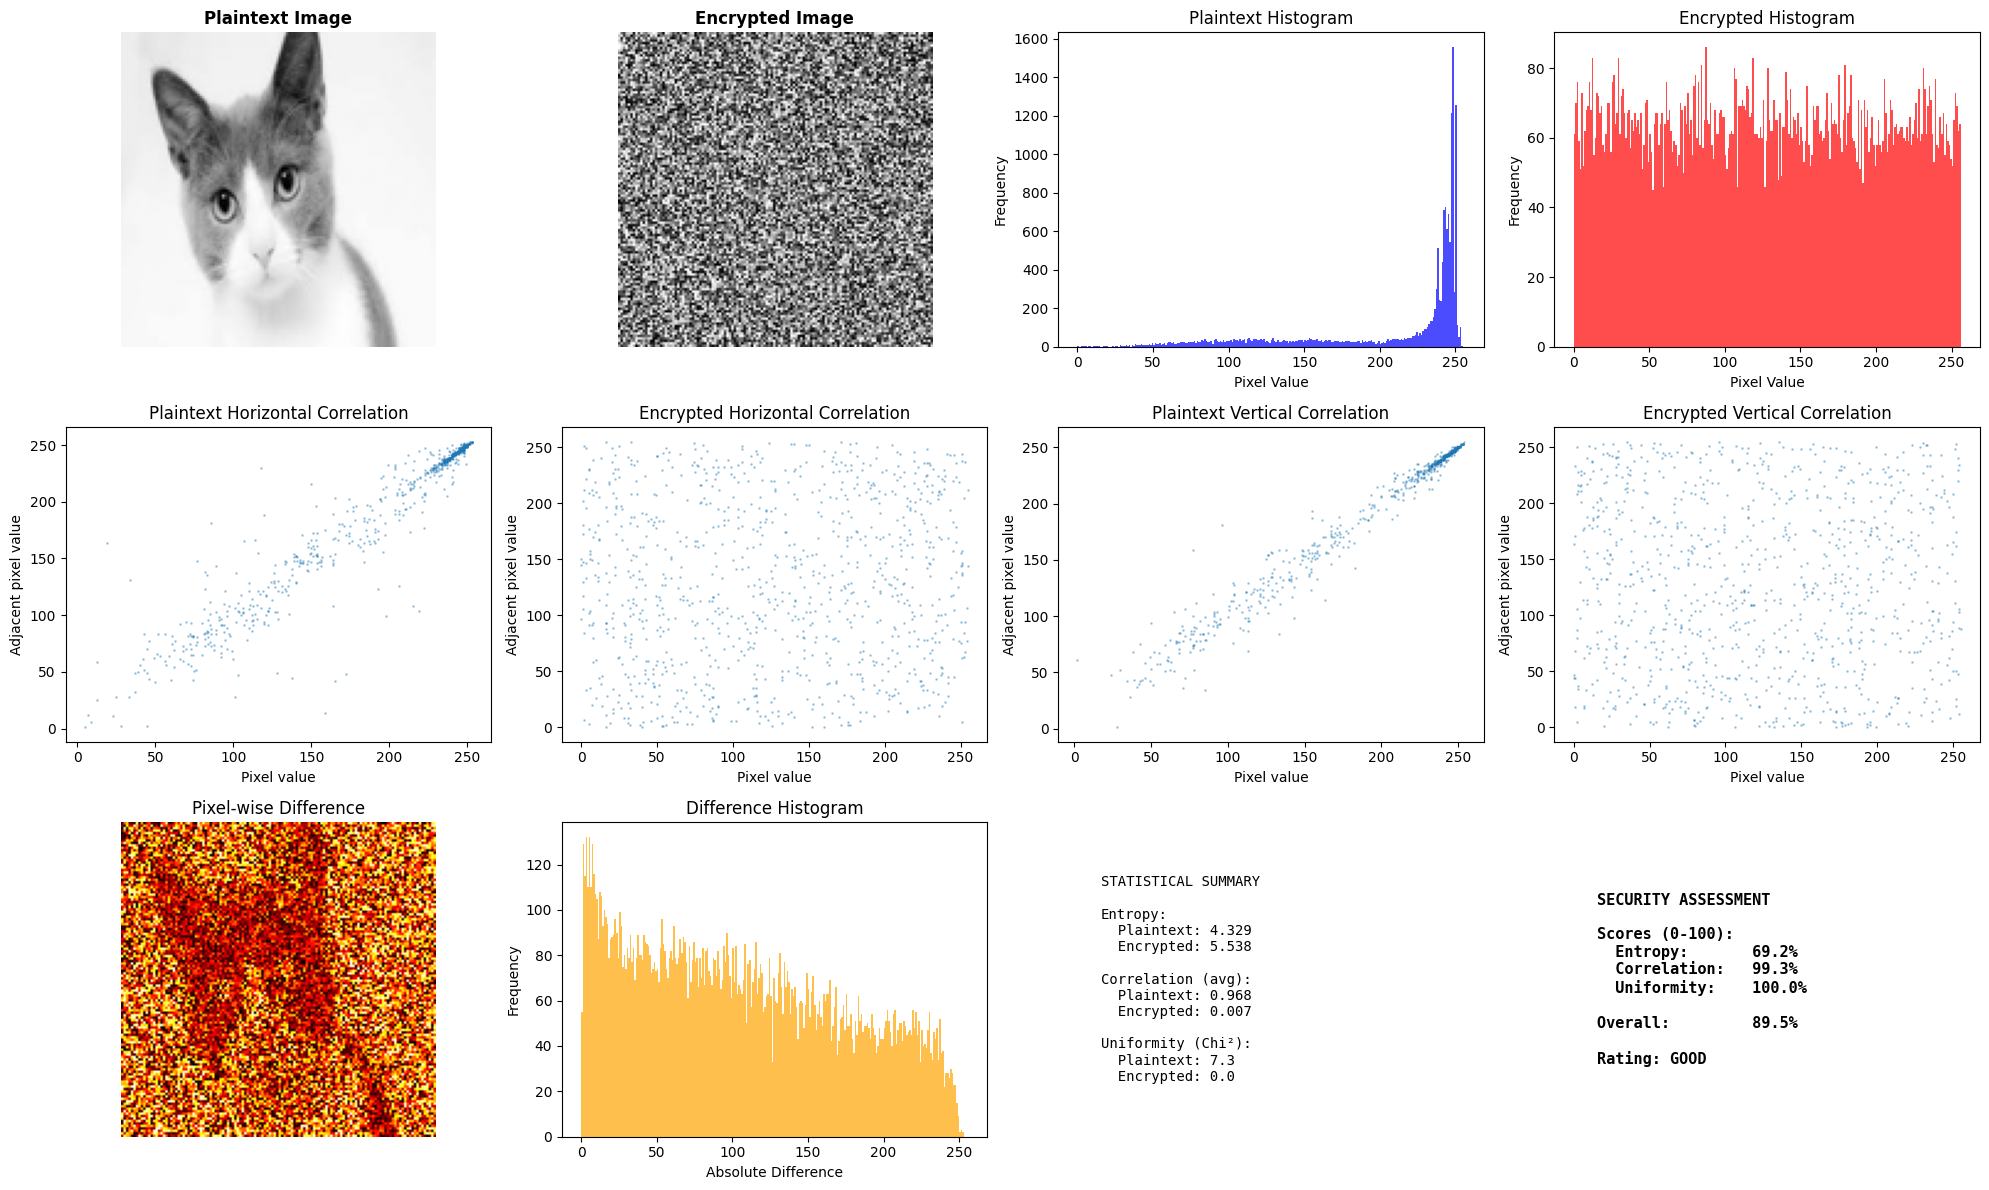


✅ Cryptanalysis complete!


In [8]:
# Run cryptanalysis on a test image
print("\n🔒 Starting Cryptanalysis Suite...")

# --- CONFIGURATION ---
# ⚠️ Change this to your test image
image_path = "images.jpg"
# ---------------------

results = run_complete_cryptanalysis(
    image_path=image_path,
    seed_d=12345,
    seed_f=67890,
    r=3.99,
    x=0.5
)

if results:
    print("\n✅ Cryptanalysis complete!")